# Walmart Sales Forecasting Project

## Sales Forecasting

Sales Forecasting is a very important area in field of business management. It helps the store retailers to maintain there stocks according to demand they are expecting, thus maximizing their profit and minimise burden of management of product stocks. It is similar to weather forecasting as both types of forecasting rely on science and historical data.
While a wrong weather forecast may result in you carrying around an umbrella on a sunny day, inaccurate business forecasts could result in actual or opportunity losses.
Forecasting can drive sales by processing just-in-time orders efficiently.

## Problem Statement

We have Sales data for Walmart Stores in 3 states(California, Texas, Wisconsin) for 3 categoies of data (HOBBIES, FOOD, HOSEHOLD) from year 2011 to 2016. We want to use this data to predict sales for next 28 days using ML techniques.

## Dataset


We have taken dataset from kaggle Competition named "M5 Forecasting - Accuracy Estimate the unit sales of Walmart retail goods"

We have been given sales of product for 1913 days amd we need to predict sales of next 28 days for each product.

We have been given several Dataframes Like:-


* calendar.csv - Contains information about the dates on which the products are sold.
* sell_prices.csv - Contains information about the price of the products sold per store and date.
* sales_train_validation.csv - Contains the historical daily unit sales data per product and store d_1 - d_1913.
* sales_train_evaluation.csv - Includes sales d_1 - d_1941.

## Metric Used

* This competition uses a Weighted Root Mean Squared Scaled Error (RMSSE).
* We have used WRMSSE instead of Simple RMSE(Root Mean Squared Error) because in this dataset there are lot of zero sales so even if our model predicts most sales near to zero our model will give good performance, WRMSSE takes this in account.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/data

/content/drive/MyDrive/data


In [3]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from lightgbm import Dataset,train,plot_importance
from sklearn import preprocessing, metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, cross_val_score, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV, RidgeCV
import gc
import os
import random
from itertools import cycle
'''
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''

"\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

In [4]:
random.seed(42)
np.random.seed(42)

In [5]:
def reduce_mem_usage(df, verbose=True):
    
    '''
    reduce the memory usage of the dataframe by downcasting 
    the int and float to avoid the memory error
    '''
    
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [6]:
def read_data(evaluation):
    
    '''
    read data and reduce memory
    '''
    
    print('Reading files...')
    
    calendar = pd.read_csv('calendar.csv')
    calendar = reduce_mem_usage(calendar)
    print('Calendar has {} rows and {} columns'.format(calendar.shape[0], calendar.shape[1]))
    
    sell_prices = pd.read_csv('sell_prices.csv')
    sell_prices = reduce_mem_usage(sell_prices)
    print('Sell prices has {} rows and {} columns'.format(sell_prices.shape[0], sell_prices.shape[1]))
    
    if evaluation:
        sales_train_validation = pd.read_csv('sales_train_evaluation.csv')
        print('Sales train validation has {} rows and {} columns'.format(sales_train_validation.shape[0], sales_train_validation.shape[1]))
    else:
        sales_train_validation = pd.read_csv('sales_train_validation.csv')
        print('Sales train validation has {} rows and {} columns'.format(sales_train_validation.shape[0], sales_train_validation.shape[1]))
          
    submission = pd.read_csv('sample_submission.csv')
    submission = reduce_mem_usage(submission)
    
    return calendar, sell_prices, sales_train_validation, submission

In [7]:
def melt_and_merge_for_eda(calendar, sell_prices, sales_train_validation, submission, nrows = 30000000):
    
    sales_train_validation = pd.melt(sales_train_validation,
                                     id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], 
                                     var_name = 'day',
                                     value_name = 'demand')
    sales_train_validation = reduce_mem_usage(sales_train_validation)
    
    test2_rows = [row for row in submission['id'] if 'evaluation' in row]
    test2 = submission[submission['id'].isin(test2_rows)]

    test2.columns = ['id', 'd_1942', 'd_1943', 'd_1944', 'd_1945', 'd_1946', 'd_1947', 'd_1948', 'd_1949', 'd_1950', 'd_1951', 'd_1952', 'd_1953', 'd_1954', 'd_1955', 'd_1956', 'd_1957', 'd_1958', 'd_1959', 
                      'd_1960', 'd_1961', 'd_1962', 'd_1963', 'd_1964', 'd_1965', 'd_1966', 'd_1967', 'd_1968', 'd_1969']

    product = sales_train_validation[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']].drop_duplicates()

    test2 = test2.merge(product, how = 'left', on = 'id')
    test2 = pd.melt(test2, 
                    id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], 
                    var_name = 'day', 
                    value_name = 'demand')

    sales_train_validation['part'] = 'train'
    test2['part'] = 'test'
    
    data = pd.concat([sales_train_validation,test2], axis = 0)
    del sales_train_validation,test2
    gc.collect()
    
    data.reset_index(drop=True,inplace=True)
    data = data.loc[30000000:]
    #calendar.drop(['weekday', 'wday', 'month', 'year'], inplace = True, axis = 1)
    data = pd.merge(data, calendar, how = 'left', left_on = ['day'], right_on = ['d'])
    data.drop(['d', 'day'], inplace = True, axis = 1)
    del calendar,product
    gc.collect()
    
    data = data.merge(sell_prices, on = ['store_id', 'item_id', 'wm_yr_wk'], how = 'left')
    del sell_prices
    gc.collect()
    
    print('Our final dataset to train has {} rows and {} columns'.format(data.shape[0], data.shape[1]))
    
    return data

In [8]:
def melt_and_merge(calendar, sell_prices, sales_train_validation, submission, nrows = 30000000):
    
    sales_train_validation = pd.melt(sales_train_validation,
                                     id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], 
                                     var_name = 'day',
                                     value_name = 'demand')
    sales_train_validation = reduce_mem_usage(sales_train_validation)
    
    test2_rows = [row for row in submission['id'] if 'evaluation' in row]
    test2 = submission[submission['id'].isin(test2_rows)]

    test2.columns = ['id', 'd_1942', 'd_1943', 'd_1944', 'd_1945', 'd_1946', 'd_1947', 'd_1948', 'd_1949', 'd_1950', 'd_1951', 'd_1952', 'd_1953', 'd_1954', 'd_1955', 'd_1956', 'd_1957', 'd_1958', 'd_1959', 
                      'd_1960', 'd_1961', 'd_1962', 'd_1963', 'd_1964', 'd_1965', 'd_1966', 'd_1967', 'd_1968', 'd_1969']

    product = sales_train_validation[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']].drop_duplicates()

    test2 = test2.merge(product, how = 'left', on = 'id')
    test2 = pd.melt(test2, 
                    id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], 
                    var_name = 'day', 
                    value_name = 'demand')

    sales_train_validation['part'] = 'train'
    test2['part'] = 'test'
    
    data = pd.concat([sales_train_validation,test2], axis = 0)
    del sales_train_validation,test2
    gc.collect()
    
    data.reset_index(drop=True,inplace=True)
    data = data.loc[30000000:]
    calendar.drop(['weekday', 'wday', 'month', 'year'], inplace = True, axis = 1)
    data = pd.merge(data, calendar, how = 'left', left_on = ['day'], right_on = ['d'])
    data.drop(['d', 'day'], inplace = True, axis = 1)
    
    data = data.merge(sell_prices, on = ['store_id', 'item_id', 'wm_yr_wk'], how = 'left')
    del calendar,sell_prices,product
    gc.collect()
    
    print('Our final dataset to train has {} rows and {} columns'.format(data.shape[0], data.shape[1]))
    
    return data

In [9]:
def transform(data):
    
    nan_features = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
    for feature in nan_features:
        data[feature].fillna('unknown', inplace = True)
                
    cat = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
    for feature in cat:
        encoder = preprocessing.LabelEncoder()
        data[feature] = encoder.fit_transform(data[feature])
        
    print('fillna and encoded')
    
    return data

In [10]:
def features_engineering(data):
    
    data['lag_t28'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28))
    data['lag_t29'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(29))
    data['lag_t30'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(30))
    data['rolling_mean_t7'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(7).mean())
    data['rolling_std_t7'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(7).std())
    data['rolling_mean_t30'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(30).mean())
    data = reduce_mem_usage(data)
    
    data['rolling_std_t30'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(30).std())
    data['rolling_skew_t30'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(30).skew())
    data['rolling_kurt_t30'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(30).kurt())
    data['rolling_mean_t90'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(90).mean())
    data['rolling_mean_t180'] = data.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(180).mean())

    data['lag_price_t1'] = data.groupby(['id'])['sell_price'].transform(lambda x: x.shift(1))
    data['price_change_t1'] = (data['lag_price_t1'] - data['sell_price']) / (data['lag_price_t1'])
    data['rolling_price_max_t365'] = data.groupby(['id'])['sell_price'].transform(lambda x: x.shift(1).rolling(365).max())
    data['price_change_t365'] = (data['rolling_price_max_t365'] - data['sell_price']) / (data['rolling_price_max_t365'])
    data['rolling_price_std_t7'] = data.groupby(['id'])['sell_price'].transform(lambda x: x.rolling(7).std())
    data['rolling_price_std_t30'] = data.groupby(['id'])['sell_price'].transform(lambda x: x.rolling(30).std())
    data.drop(['rolling_price_max_t365', 'lag_price_t1'], inplace = True, axis = 1)
    
    data['date'] = pd.to_datetime(data['date'])
    data['year'] = data['date'].dt.year
    data['month'] = data['date'].dt.month
    data['week'] = data['date'].dt.week
    data['day'] = data['date'].dt.day
    data['dayofweek'] = data['date'].dt.dayofweek
    data['isweekend'] = data['dayofweek'].apply(lambda x: 1 if x==5 or x==6 else 0)
    
    data['revenue'] = data['demand'] * data['sell_price']
    data['lag_revenue_t1'] = data.groupby(['id'])['revenue'].transform(lambda x: x.shift(28))
    data['rolling_revenue_std_t28'] = data.groupby(['id'])['lag_revenue_t1'].transform(lambda x: x.rolling(28).std())
    data['rolling_revenue_mean_t28'] = data.groupby(['id'])['lag_revenue_t1'].transform(lambda x: x.rolling(28).mean())
    data.drop(['revenue'],axis=1,inplace=True)
    data = reduce_mem_usage(data)
    
    return data

In [11]:
def split_data(data):
    x_train = data[data['part'] == 'train']
    y_train = x_train['demand']
    x_val = data[(data['date'] > '2016-04-24') & (data['part'] == 'train')]
    y_val = x_val['demand']
    test = data[data['date'] > '2016-04-24']
    test.loc[test['part']=='train','id'] = test.loc[test['part']=='train','id'].str.replace('_evaluation','_validation')
    x_train.drop(['demand','part',],inplace=True,axis=1)
    x_val.drop(['demand','part',],inplace=True,axis=1)
    test.drop(['demand','part',],inplace=True,axis=1)
    
    del data
    gc.collect()
    
    return x_train, y_train, x_val, y_val, test

In [12]:
def dataset(category,category2):
    
    tindex = x_train[(x_train['dept_id']==category) & (x_train['store_id']==category2)].index.values
    vindex = x_val[(x_val['dept_id']==category)&(x_val['store_id']==category2)].index.values
    
    x_t,x_v,y_t,y_v,t =  x_train[(x_train['dept_id']==category) & (x_train['store_id']==category2)],x_val[(x_val['dept_id']==category)&(x_val['store_id']==category2)],y_train.loc[tindex],y_val.loc[vindex],test[(test['dept_id']==category) &(test['store_id']==category2)]
    
    x_train.drop(tindex,axis=0,inplace=True)
    x_val.drop(vindex,axis=0,inplace=True)
    test.drop(test[(test['dept_id']==category) &(test['store_id']==category2)].index.values,axis=0,inplace=True)
    
    return x_t,x_v,y_t,y_v,t

In [13]:
calendar, sell_prices, sales_train_validation, submission = read_data(True)

Reading files...
Mem. usage decreased to  0.12 Mb (41.9% reduction)
Calendar has 1969 rows and 14 columns
Mem. usage decreased to 130.48 Mb (37.5% reduction)
Sell prices has 6841121 rows and 4 columns
Sales train validation has 30490 rows and 1947 columns
Mem. usage decreased to  2.09 Mb (84.5% reduction)


In [14]:
print("Shape of calender.csv", calendar.shape)
print("Shape of sell_price.csv", sell_prices.shape)
print("Shape of sales_train_validation.csv", sales_train_validation.shape)
print("Shape of submission.csv",submission.shape)

Shape of calender.csv (1969, 14)
Shape of sell_price.csv (6841121, 4)
Shape of sales_train_validation.csv (30490, 1947)
Shape of submission.csv (60980, 29)


In [15]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [16]:
sell_prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.578125
1,CA_1,HOBBIES_1_001,11326,9.578125
2,CA_1,HOBBIES_1_001,11327,8.257812
3,CA_1,HOBBIES_1_001,11328,8.257812
4,CA_1,HOBBIES_1_001,11329,8.257812


In [17]:
sales_train_validation.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51,d_52,d_53,d_54,d_55,d_56,d_57,d_58,d_59,d_60,d_61,d_62,d_63,d_64,d_65,d_66,d_67,d_68,d_69,d_70,d_71,d_72,d_73,d_74,d_75,d_76,d_77,d_78,d_79,d_80,d_81,d_82,d_83,d_84,d_85,d_86,d_87,d_88,d_89,d_90,d_91,d_92,d_93,d_94,d_95,d_96,d_97,d_98,d_99,d_100,d_101,d_102,d_103,d_104,d_105,d_106,d_107,d_108,d_109,d_110,d_111,d_112,d_113,d_114,d_115,d_116,d_117,d_118,d_119,d_120,d_121,d_122,d_123,d_124,d_125,d_126,d_127,d_128,d_129,d_130,d_131,d_132,d_133,d_134,d_135,d_136,d_137,d_138,d_139,d_140,d_141,d_142,d_143,d_144,d_145,d_146,d_147,d_148,d_149,d_150,d_151,d_152,d_153,d_154,d_155,d_156,d_157,d_158,d_159,d_160,d_161,d_162,d_163,d_164,d_165,d_166,d_167,d_168,d_169,d_170,d_171,d_172,d_173,d_174,d_175,d_176,d_177,d_178,d_179,d_180,d_181,d_182,d_183,d_184,d_185,d_186,d_187,d_188,d_189,d_190,d_191,d_192,d_193,d_194,d_195,d_196,d_197,d_198,d_199,d_200,d_201,d_202,d_203,d_204,d_205,d_206,d_207,d_208,d_209,d_210,d_211,d_212,d_213,d_214,d_215,d_216,d_217,d_218,d_219,d_220,d_221,d_222,d_223,d_224,d_225,d_226,d_227,d_228,d_229,d_230,d_231,d_232,d_233,d_234,d_235,d_236,d_237,d_238,d_239,d_240,d_241,d_242,d_243,d_244,...,d_1692,d_1693,d_1694,d_1695,d_1696,d_1697,d_1698,d_1699,d_1700,d_1701,d_1702,d_1703,d_1704,d_1705,d_1706,d_1707,d_1708,d_1709,d_1710,d_1711,d_1712,d_1713,d_1714,d_1715,d_1716,d_1717,d_1718,d_1719,d_1720,d_1721,d_1722,d_1723,d_1724,d_1725,d_1726,d_1727,d_1728,d_1729,d_1730,d_1731,d_1732,d_1733,d_1734,d_1735,d_1736,d_1737,d_1738,d_1739,d_1740,d_1741,d_1742,d_1743,d_1744,d_1745,d_1746,d_1747,d_1748,d_1749,d_1750,d_1751,d_1752,d_1753,d_1754,d_1755,d_1756,d_1757,d_1758,d_1759,d_1760,d_1761,d_1762,d_1763,d_1764,d_1765,d_1766,d_1767,d_1768,d_1769,d_1770,d_1771,d_1772,d_1773,d_1774,d_1775,d_1776,d_1777,d_1778,d_1779,d_1780,d_1781,d_1782,d_1783,d_1784,d_1785,d_1786,d_1787,d_1788,d_1789,d_1790,d_1791,d_1792,d_1793,d_1794,d_1795,d_1796,d_1797,d_1798,d_1799,d_1800,d_1801,d_1802,d_1803,d_1804,d_1805,d_1806,d_1807,d_1808,d_1809,d_1810,d_1811,d_1812,d_1813,d_1814,d_1815,d_1816,d_1817,d_1818,d_1819,d_1820,d_1821,d_1822,d_1823,d_1824,d_1825,d_1826,d_1827,d_1828,d_1829,d_1830,d_1831,d_1832,d_1833,d_1834,d_1835,d_1836,d_1837,d_1838,d_1839,d_1840,d_1841,d_1842,d_1843,d_1844,d_1845,d_1846,d_1847,d_1848,d_1849,d_1850,d_1851,d_1852,d_1853,d_1854,d_1855,d_1856,d_1857,d_1858,d_1859,d_1860,d_1861,d_1862,d_1863,d_1864,d_1865,d_1866,d_1867,d_1868,d_1869,d_1870,d_1871,d_1872,d_1873,d_1874,d_1875,d_1876,d_1877,d_1878,d_1879,d_1880,d_1881,d_1882,d_1883,d_1884,d_1885,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,1,0,1,0,1,0,3,1,1,0,1,1,2,0,0,0,0,1,1,0,0,0,0,3,0,1,0,0,0,0,1,1,1,0,1,0,2,0,0,0,0,2,0,0,0,0,1,1,2,0,0,0,0,2,0,0,1,1,1,1,0,0,0,0,0,1,2,2,0,1,0,0,0,0,1,2,1,0,0,0,0,0,1,0,3,0,1,2,1,0,3,0,0,0,1,0,2,2,1,0,0,1,2,0,1,0,1,4,0,0,5,0,0,0,0,0,0,2,1,2,1,0,0,0,1,1,1,0,0,1,1,1,1

In [18]:
submission.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [19]:
data = melt_and_merge_for_eda(calendar, sell_prices, sales_train_validation,
                      submission, nrows = 30000000)

Mem. usage decreased to 3273.49 Mb (9.4% reduction)
Our final dataset to train has 30034810 rows and 22 columns


In [20]:
nan_features = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
for feature in nan_features:
    data[feature].fillna('unknown', inplace = True)

In [21]:
data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,demand,part,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOUSEHOLD_1_331_WI_3_evaluation,HOUSEHOLD_1_331,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,0,train,2013-10-08,11337,Tuesday,4,10,2013,unknown,unknown,unknown,unknown,1,0,1,4.878906
1,HOUSEHOLD_1_332_WI_3_evaluation,HOUSEHOLD_1_332,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,0,train,2013-10-08,11337,Tuesday,4,10,2013,unknown,unknown,unknown,unknown,1,0,1,NaN
2,HOUSEHOLD_1_333_WI_3_evaluation,HOUSEHOLD_1_333,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,0,train,2013-10-08,11337,Tuesday,4,10,2013,unknown,unknown,unknown,unknown,1,0,1,2.970703
3,HOUSEHOLD_1_334_WI_3_evaluation,HOUSEHOLD_1_334,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,11,train,2013-10-08,11337,Tuesday,4,10,2013,unknown,unknown,unknown,unknown,1,0,1,0.979980
4,HOUSEHOLD_1_335_WI_3_evaluation,HOUSEHOLD_1_335,HOUSEHOLD_1,HOUSEHOLD,WI_3,WI,0,train,2013-10-08,11337,Tuesday,4,10,2013,unknown,unknown,unknown,unknown,1,0,1,8.968750


In [22]:
data.columns.values

array(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id',
       'demand', 'part', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month',
       'year', 'event_name_1', 'event_type_1', 'event_name_2',
       'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI', 'sell_price'],
      dtype=object)

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30034810 entries, 0 to 30034809
Data columns (total 22 columns):
 #   Column        Dtype  
---  ------        -----  
 0   id            object 
 1   item_id       object 
 2   dept_id       object 
 3   cat_id        object 
 4   store_id      object 
 5   state_id      object 
 6   demand        int16  
 7   part          object 
 8   date          object 
 9   wm_yr_wk      int16  
 10  weekday       object 
 11  wday          int8   
 12  month         int8   
 13  year          int16  
 14  event_name_1  object 
 15  event_type_1  object 
 16  event_name_2  object 
 17  event_type_2  object 
 18  snap_CA       int8   
 19  snap_TX       int8   
 20  snap_WI       int8   
 21  sell_price    float16
dtypes: float16(1), int16(3), int8(5), object(13)
memory usage: 3.5+ GB


In [24]:
data['store_id'].unique()

array(['WI_3', 'CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3',
       'WI_1', 'WI_2'], dtype=object)

In [25]:
data['state_id'].unique()

array(['WI', 'CA', 'TX'], dtype=object)

In [26]:
(data['date'].min(), data['date'].max())

('2013-10-08', '2016-06-19')

In [28]:
sales_train_validation = pd.read_csv('sales_train_evaluation.csv')
sales_train_validation = reduce_mem_usage(sales_train_validation)

Mem. usage decreased to 96.13 Mb (78.8% reduction)


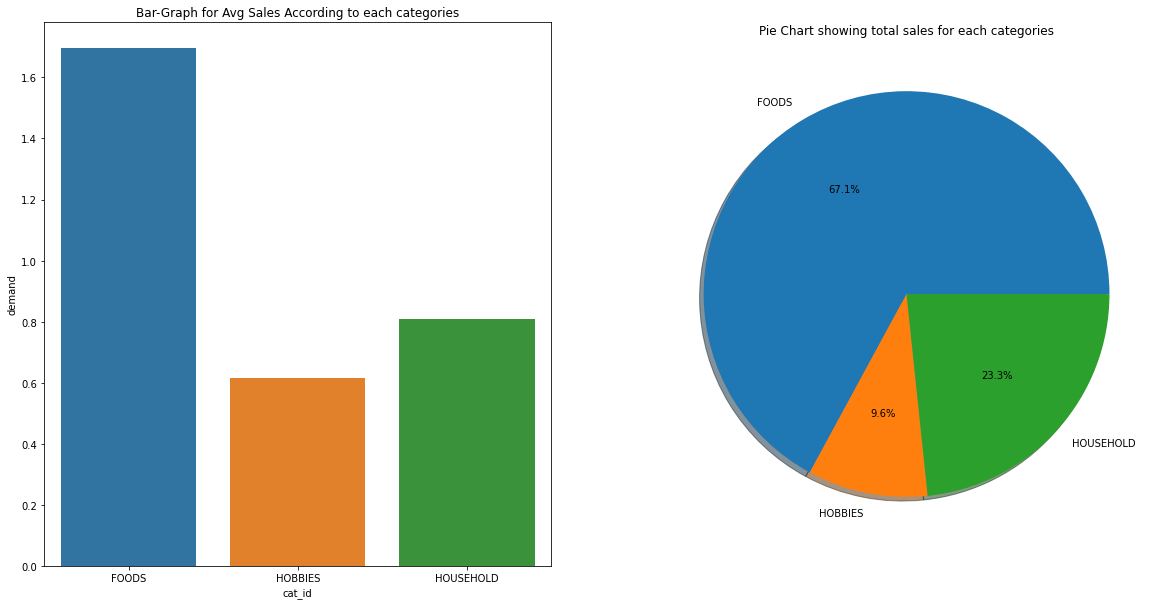

In [29]:
df=data.groupby('cat_id').mean()
df.reset_index(level=0,inplace=True)
plt.figure(figsize=(20,10))
plt.subplot(121)
sns.barplot(x='cat_id',y='demand',data=df)
plt.title("Bar-Graph for Avg Sales According to each categories")

plt.subplot(122)
df=data.groupby('cat_id').sum()
df.reset_index(level=0,inplace=True)
df['perc']=df['demand']/sum(df['demand'].values)*100
plt.pie(df['perc'].values,labels=df['cat_id'].values,shadow=True,autopct='%1.1f%%')
plt.title("Pie Chart showing total sales for each categories")

plt.show()

Total sales for FOODS is the most.

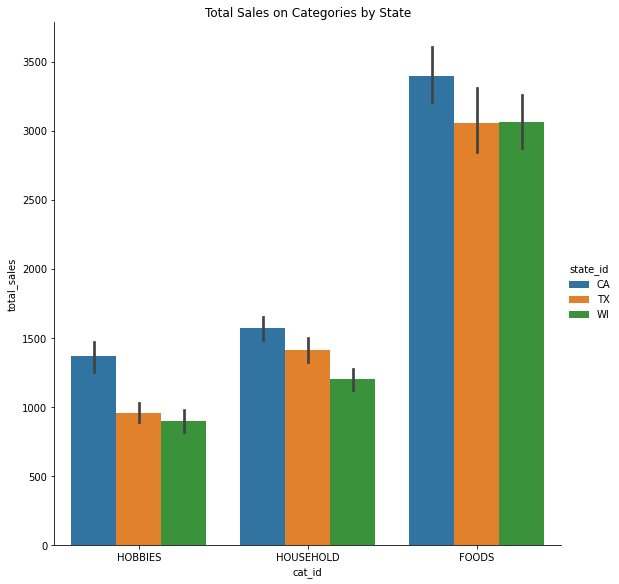

In [30]:
sales_train_validation['total_sales'] = sales_train_validation.sum(axis=1)
sns.catplot(x='cat_id', y='total_sales',
           hue='state_id',
           data=sales_train_validation, kind='bar',
           height=8, aspect=1)
plt.title('Total Sales on Categories by State')
plt.show()

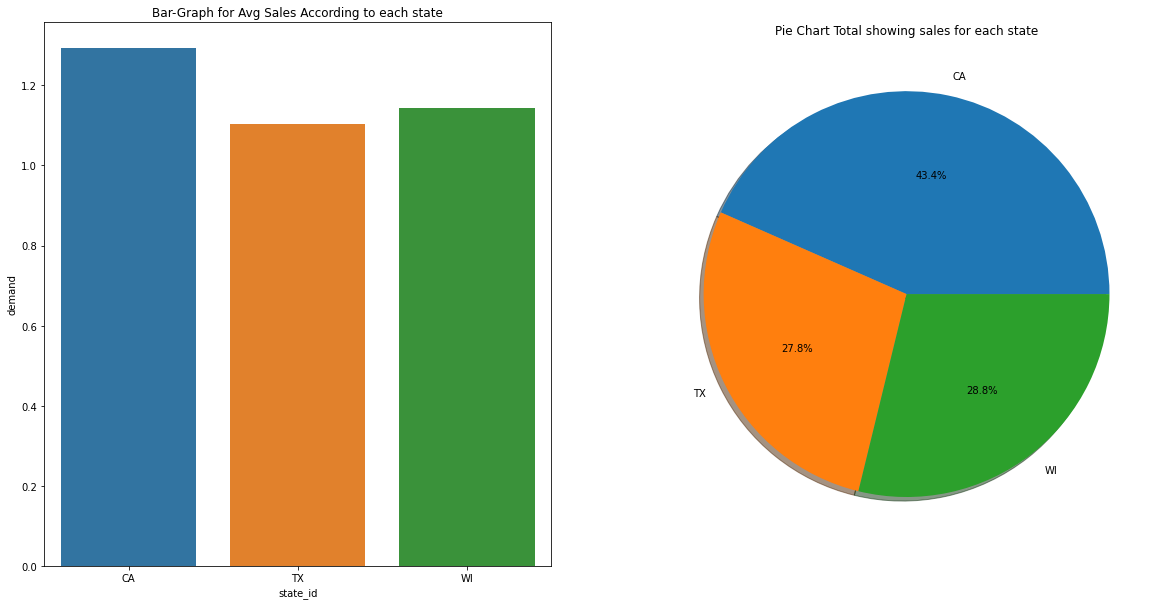

In [31]:
df=data.groupby('state_id').mean()
df.reset_index(level=0,inplace=True)
plt.figure(figsize=(20,10))
plt.subplot(121)
sns.barplot(x='state_id',y='demand',data=df)
plt.title("Bar-Graph for Avg Sales According to each state")

df=data.groupby('state_id').sum()
df.reset_index(level=0,inplace=True)
df['perc']=df['demand']/sum(df['demand'].values)*100
plt.subplot(122)
plt.pie(df['perc'].values,labels=df['state_id'].values,shadow=True,autopct='%1.1f%%')
plt.title("Pie Chart Total showing sales for each state")

plt.show()

California has the most sales. The reason might be because California has the most population compares to the other two states.

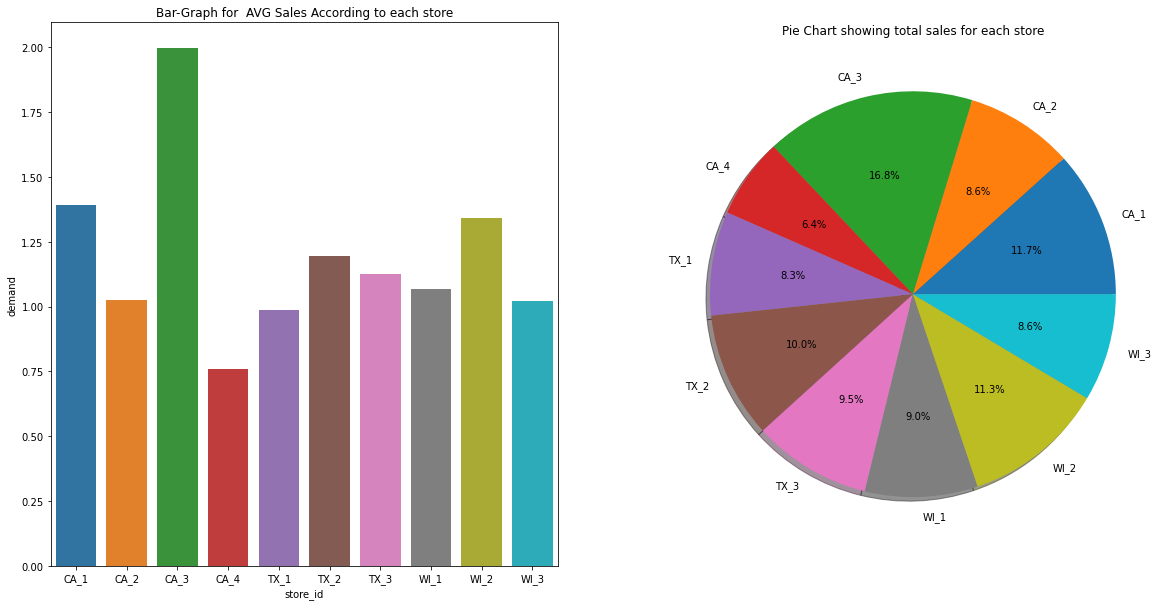

In [32]:
df=data.groupby('store_id').mean()
df.reset_index(level=0,inplace=True)
plt.figure(figsize=(20,10))
plt.subplot(121)
sns.barplot(x='store_id',y='demand',data=df)
plt.title("Bar-Graph for  AVG Sales According to each store")
df=data.groupby('store_id').sum()
df.reset_index(level=0,inplace=True)
df['perc']=df['demand']/sum(df['demand'].values)*100
plt.subplot(122)
plt.pie(df['perc'].values,labels=df['store_id'].values,shadow=True,autopct='%1.1f%%')
plt.title("Pie Chart showing total sales for each store")

plt.show()

At store CA_3, total sales is the most and it might be a cause of highest state sales.
Store WI_2 is also interesting, it has a lot of sales compares to another stores in the state.

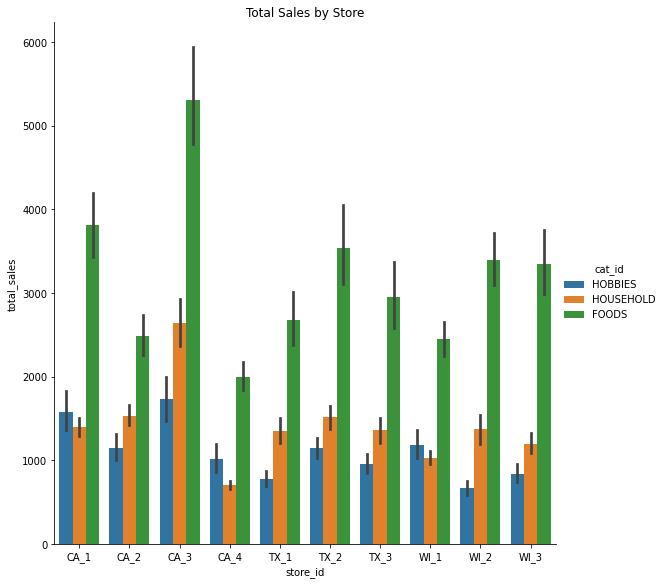

In [33]:
sns.catplot(x='store_id', y='total_sales',
           hue='cat_id',
           data=sales_train_validation, kind='bar',
           height=8, aspect=1)
plt.title('Total Sales by Store')
plt.show()

Usually HOUSEHOLD product sales more than HOBBIES, but some store has HOBBIES product sales more than HOUSEHOLD.

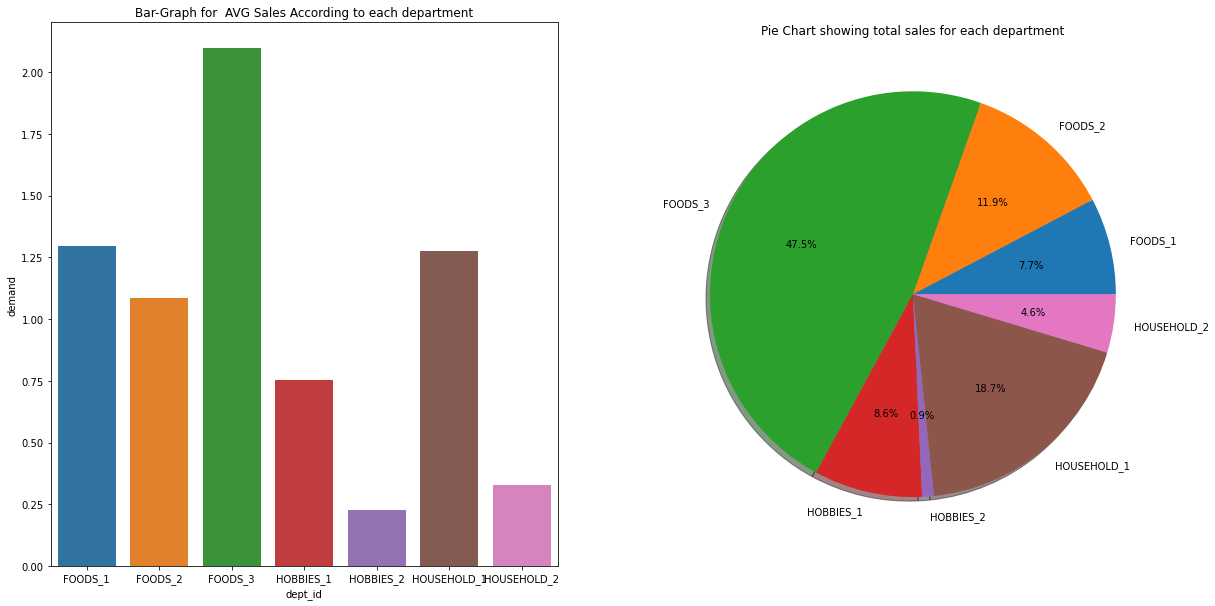

In [34]:
df=data.groupby('dept_id').mean()
df.reset_index(level=0,inplace=True)
plt.figure(figsize=(20,10))
plt.subplot(121)
sns.barplot(x='dept_id',y='demand',data=df)
plt.title("Bar-Graph for  AVG Sales According to each department")
df=data.groupby('dept_id').sum()
df.reset_index(level=0,inplace=True)
df['perc']=df['demand']/sum(df['demand'].values)*100
plt.subplot(122)
plt.pie(df['perc'].values,labels=df['dept_id'].values,shadow=True,autopct='%1.1f%%')
plt.title("Pie Chart showing total sales for each department")

plt.show()

Almost 50% of the sales are done by FOODS_3 department.

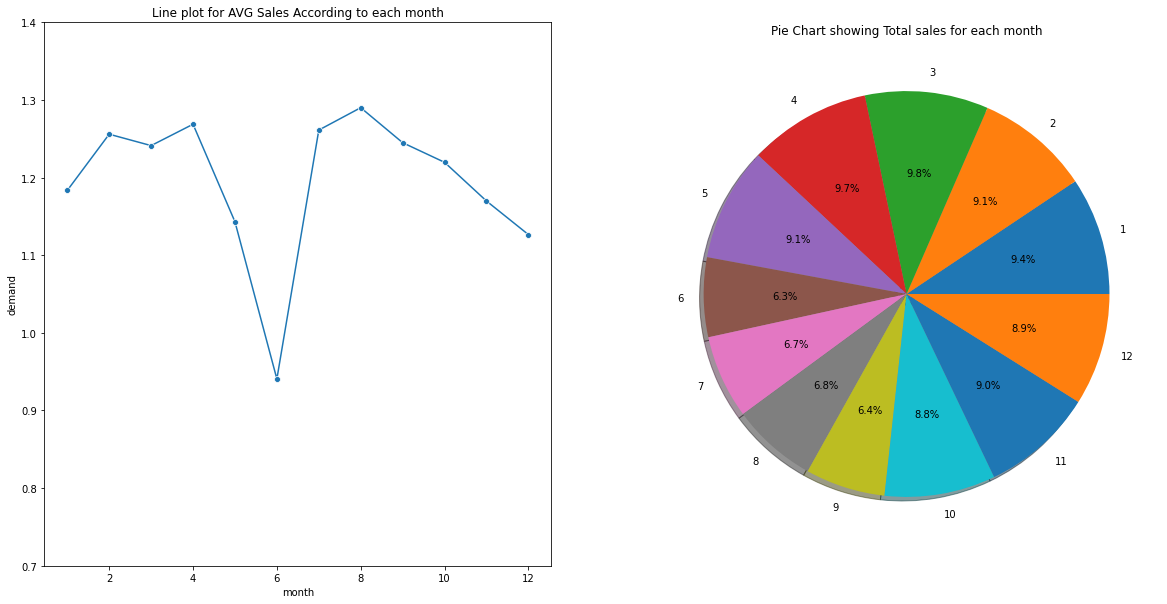

In [35]:
df=data.groupby('month').mean()
df.reset_index(level=0,inplace=True)
plt.figure(figsize=(20,10))
plt.subplot(121)
sns.lineplot(x='month',y='demand',data=df, marker="o")
plt.yticks(np.arange(0.7, 1.5, 0.1))
plt.title("Line plot for AVG Sales According to each month")

df=data.groupby('month').sum()
df.reset_index(level=0,inplace=True)
df['perc']=df['demand']/sum(df['demand'].values)*100
plt.subplot(122)
plt.pie(df['perc'].values,labels=df['month'].values,shadow=True,autopct='%1.1f%%')
plt.title("Pie Chart showing Total sales for each month")

plt.show()

There are some seasonality in month sales data.

In [36]:
hobbies_state = sales_train_validation.loc[(sales_train_validation['cat_id'] == 'HOBBIES')].groupby(['state_id']).mean().T
hobbies_state = hobbies_state.rename({'CA': 'HOBBIES_CA', 'TX': 'HOBBIES_TX', 'WI': 'HOBBIES_WI'}, axis=1)
household_state = sales_train_validation.loc[(sales_train_validation['cat_id'] == 'HOUSEHOLD')].groupby(['state_id']).mean().T
household_state = household_state.rename({'CA': 'HOUSEHOLD_CA', 'TX': 'HOUSEHOLD_TX', 'WI': 'HOUSEHOLD_WI'}, axis=1)
foods_state = sales_train_validation.loc[(sales_train_validation['cat_id'] == 'FOODS')].groupby(['state_id']).mean().T
foods_state = foods_state.rename({'CA': 'FOODS_CA', 'TX': 'FOODS_TX', 'WI': 'FOODS_WI'}, axis=1)
nine_example = pd.concat([hobbies_state, household_state, foods_state], axis=1)
nine_example = nine_example.drop('total_sales')

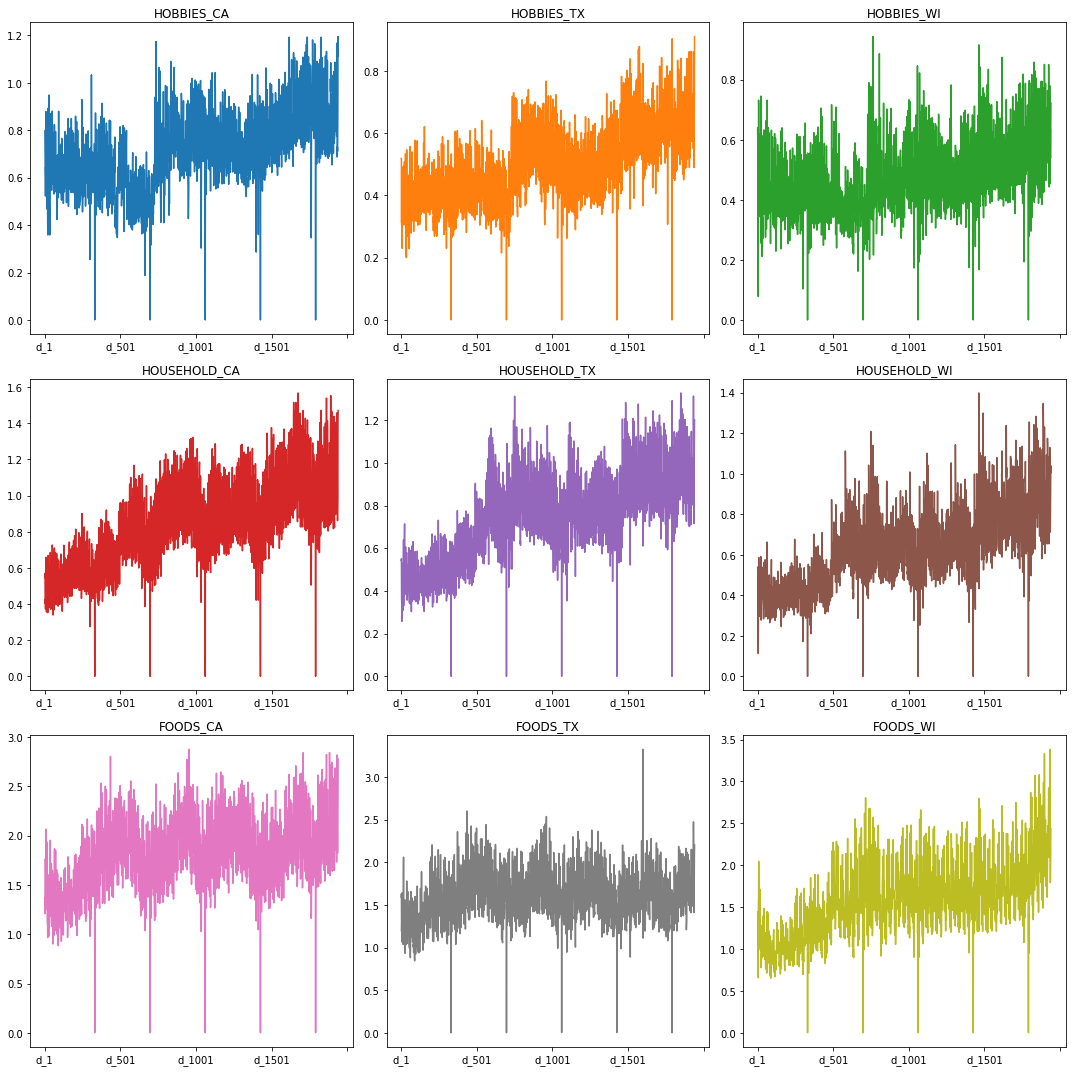

In [37]:
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

fig, axs = plt.subplots(3, 3, figsize=(15,15))
axs = axs.flatten()
ax_idx = 0
for item in nine_example.columns:
    nine_example[item].plot(title=item, color=next(color_cycle), ax=axs[ax_idx])
    ax_idx += 1
plt.tight_layout()
plt.show()

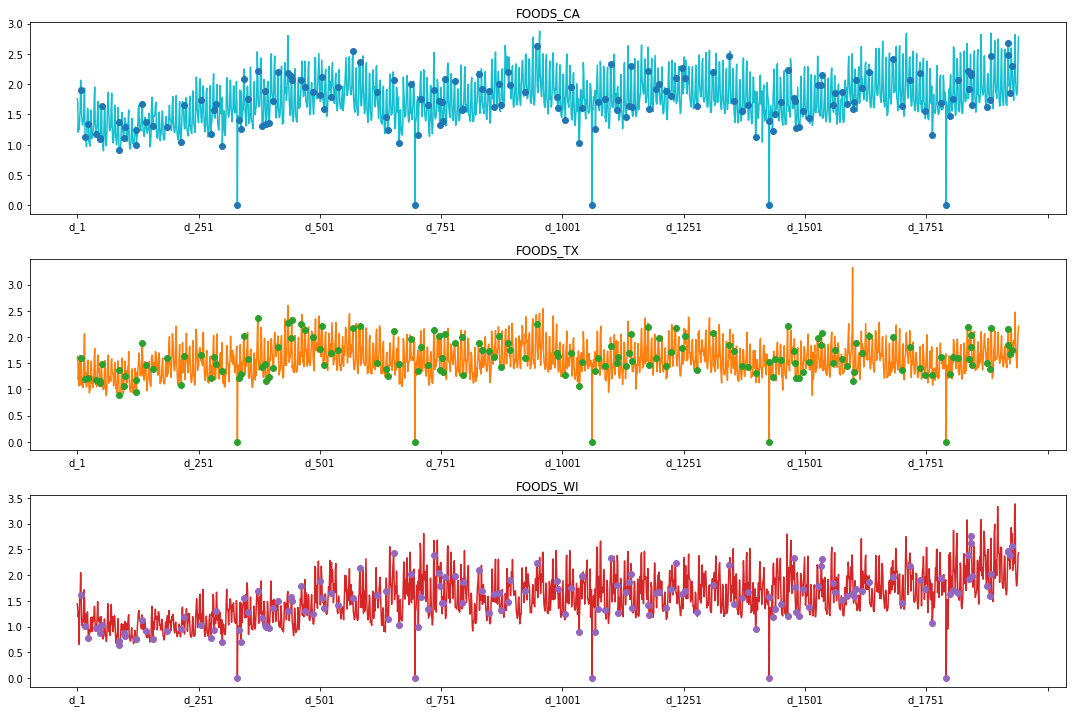

In [38]:
event_date = calendar.loc[calendar['event_name_1'].isin(calendar.event_name_1.unique()[1:])].d
FOODS_event = sales_train_validation.loc[(sales_train_validation['cat_id'] == 'FOODS')].groupby(['state_id']).mean().T.reset_index()
FOODS_event = FOODS_event.loc[FOODS_event['index'].isin(event_date)]
plt.figure(figsize=(15, 10))
plt.subplot(3,1,1)
nine_example['FOODS_CA'].plot(title='FOODS_CA', color=next(color_cycle))
plt.scatter(FOODS_event.reset_index().level_0, FOODS_event['CA'],color=next(color_cycle), zorder=10)
plt.subplot(3,1,2)
nine_example['FOODS_TX'].plot(title='FOODS_TX', color=next(color_cycle))
plt.scatter(FOODS_event.reset_index().level_0, FOODS_event['TX'],color=next(color_cycle), zorder=10)
plt.subplot(3,1,3)
nine_example['FOODS_WI'].plot(title='FOODS_WI', color=next(color_cycle))
plt.scatter(FOODS_event.reset_index().level_0, FOODS_event['WI'],color=next(color_cycle), zorder=10)
plt.tight_layout()
plt.show()

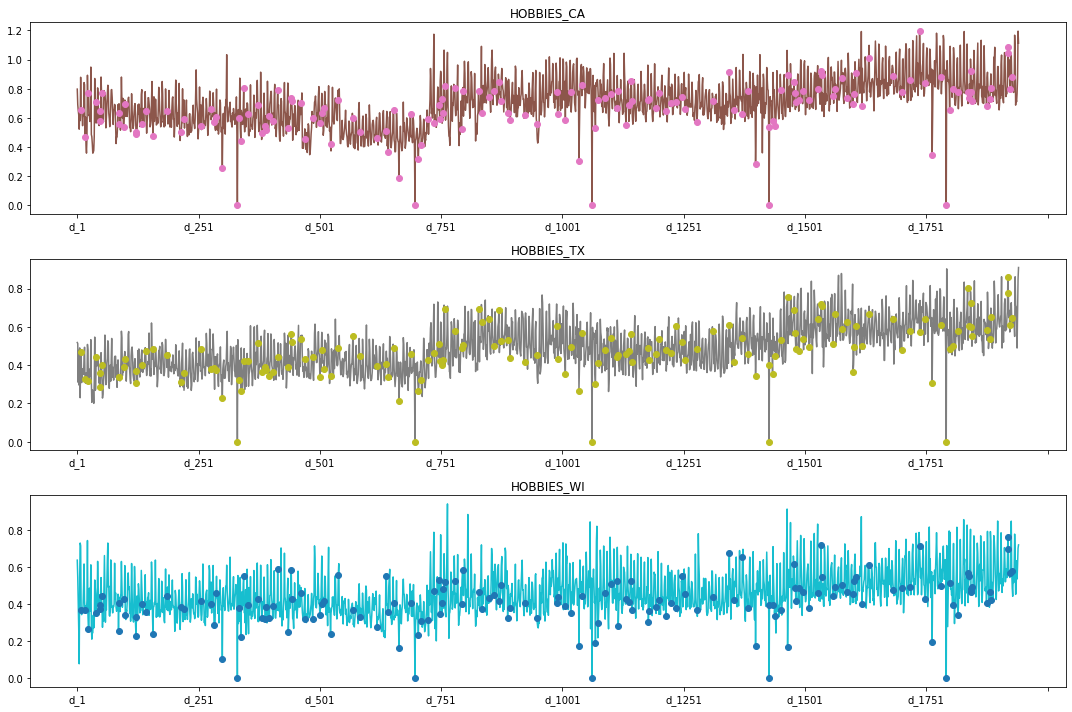

In [39]:
HOBBIES_event = sales_train_validation.loc[(sales_train_validation['cat_id'] == 'HOBBIES')].groupby(['state_id']).mean().T.reset_index()
HOBBIES_event = HOBBIES_event.loc[HOBBIES_event['index'].isin(event_date)]
plt.figure(figsize=(15, 10))
plt.subplot(3,1,1)
nine_example['HOBBIES_CA'].plot(title='HOBBIES_CA', color=next(color_cycle))
plt.scatter(HOBBIES_event.reset_index().level_0, HOBBIES_event['CA'],color=next(color_cycle), zorder=10)
plt.subplot(3,1,2)
nine_example['HOBBIES_TX'].plot(title='HOBBIES_TX', color=next(color_cycle))
plt.scatter(HOBBIES_event.reset_index().level_0, HOBBIES_event['TX'],color=next(color_cycle), zorder=10)
plt.subplot(3,1,3)
nine_example['HOBBIES_WI'].plot(title='HOBBIES_WI', color=next(color_cycle))
plt.scatter(HOBBIES_event.reset_index().level_0, HOBBIES_event['WI'],color=next(color_cycle), zorder=10)
plt.tight_layout()
plt.show()

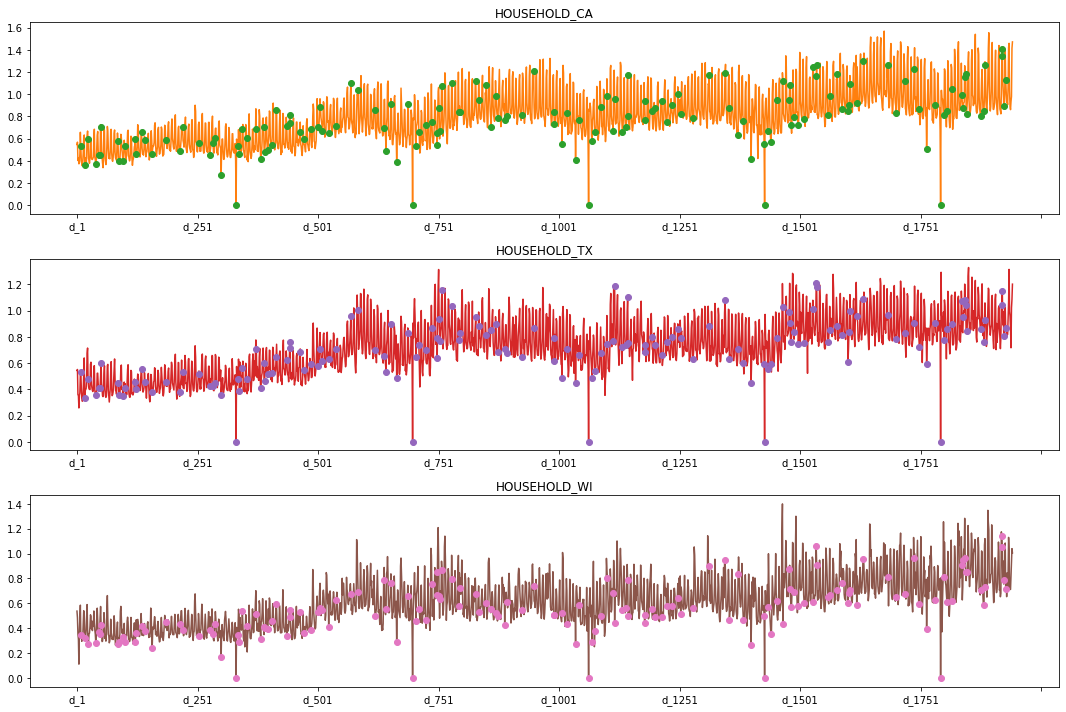

In [40]:
HOUSEHOLD_event = sales_train_validation.loc[(sales_train_validation['cat_id'] == 'HOUSEHOLD')].groupby(['state_id']).mean().T.reset_index()
HOUSEHOLD_event = HOUSEHOLD_event.loc[HOUSEHOLD_event['index'].isin(event_date)]
plt.figure(figsize=(15, 10))
plt.subplot(3,1,1)
nine_example['HOUSEHOLD_CA'].plot(title='HOUSEHOLD_CA', color=next(color_cycle))
plt.scatter(HOUSEHOLD_event.reset_index().level_0, HOUSEHOLD_event['CA'],color=next(color_cycle), zorder=10)
plt.subplot(3,1,2)
nine_example['HOUSEHOLD_TX'].plot(title='HOUSEHOLD_TX', color=next(color_cycle))
plt.scatter(HOUSEHOLD_event.reset_index().level_0, HOUSEHOLD_event['TX'],color=next(color_cycle), zorder=10)
plt.subplot(3,1,3)
nine_example['HOUSEHOLD_WI'].plot(title='HOUSEHOLD_WI', color=next(color_cycle))
plt.scatter(HOUSEHOLD_event.reset_index().level_0, HOUSEHOLD_event['WI'],color=next(color_cycle), zorder=10)
plt.tight_layout()
plt.show()

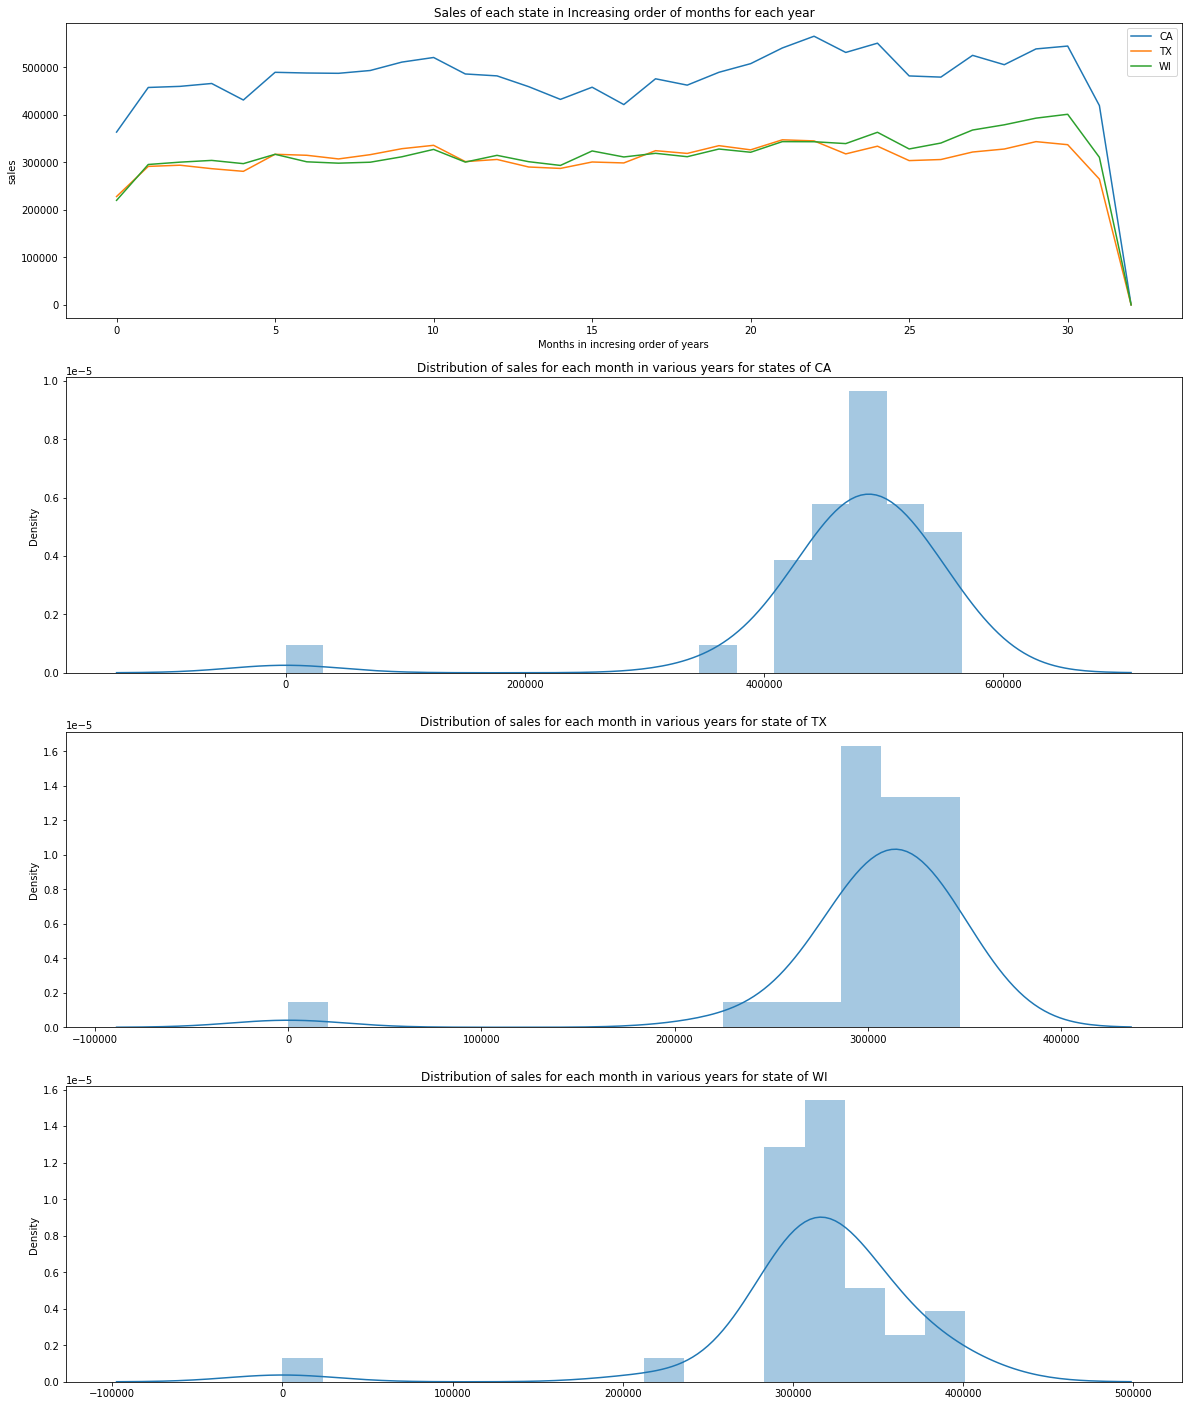

In [41]:
df=data.groupby(['year','month','state_id']).sum()
df.reset_index(level=[0,1,2],inplace=True)
plt.figure(figsize=(20,25))
plt.subplot(411)
plt.plot(df[df['state_id']=="CA"]['demand'].values,label="CA")
plt.plot(df[df['state_id']=="TX"]['demand'].values,label="TX")
plt.plot(df[df['state_id']=="WI"]['demand'].values,label="WI")
plt.xlabel('Months in incresing order of years')
plt.ylabel('sales')
plt.title("Sales of each state in Increasing order of months for each year")
plt.legend()

plt.subplot(412)
sns.distplot(df[df['state_id']=="CA"]['demand'].values)
plt.title("Distribution of sales for each month in various years for states of CA")

plt.subplot(413)
sns.distplot(df[df['state_id']=="TX"]['demand'].values)
plt.title("Distribution of sales for each month in various years for state of TX")

plt.subplot(414)
sns.distplot(df[df['state_id']=="WI"]['demand'].values)
plt.title("Distribution of sales for each month in various years for state of WI")

plt.show()

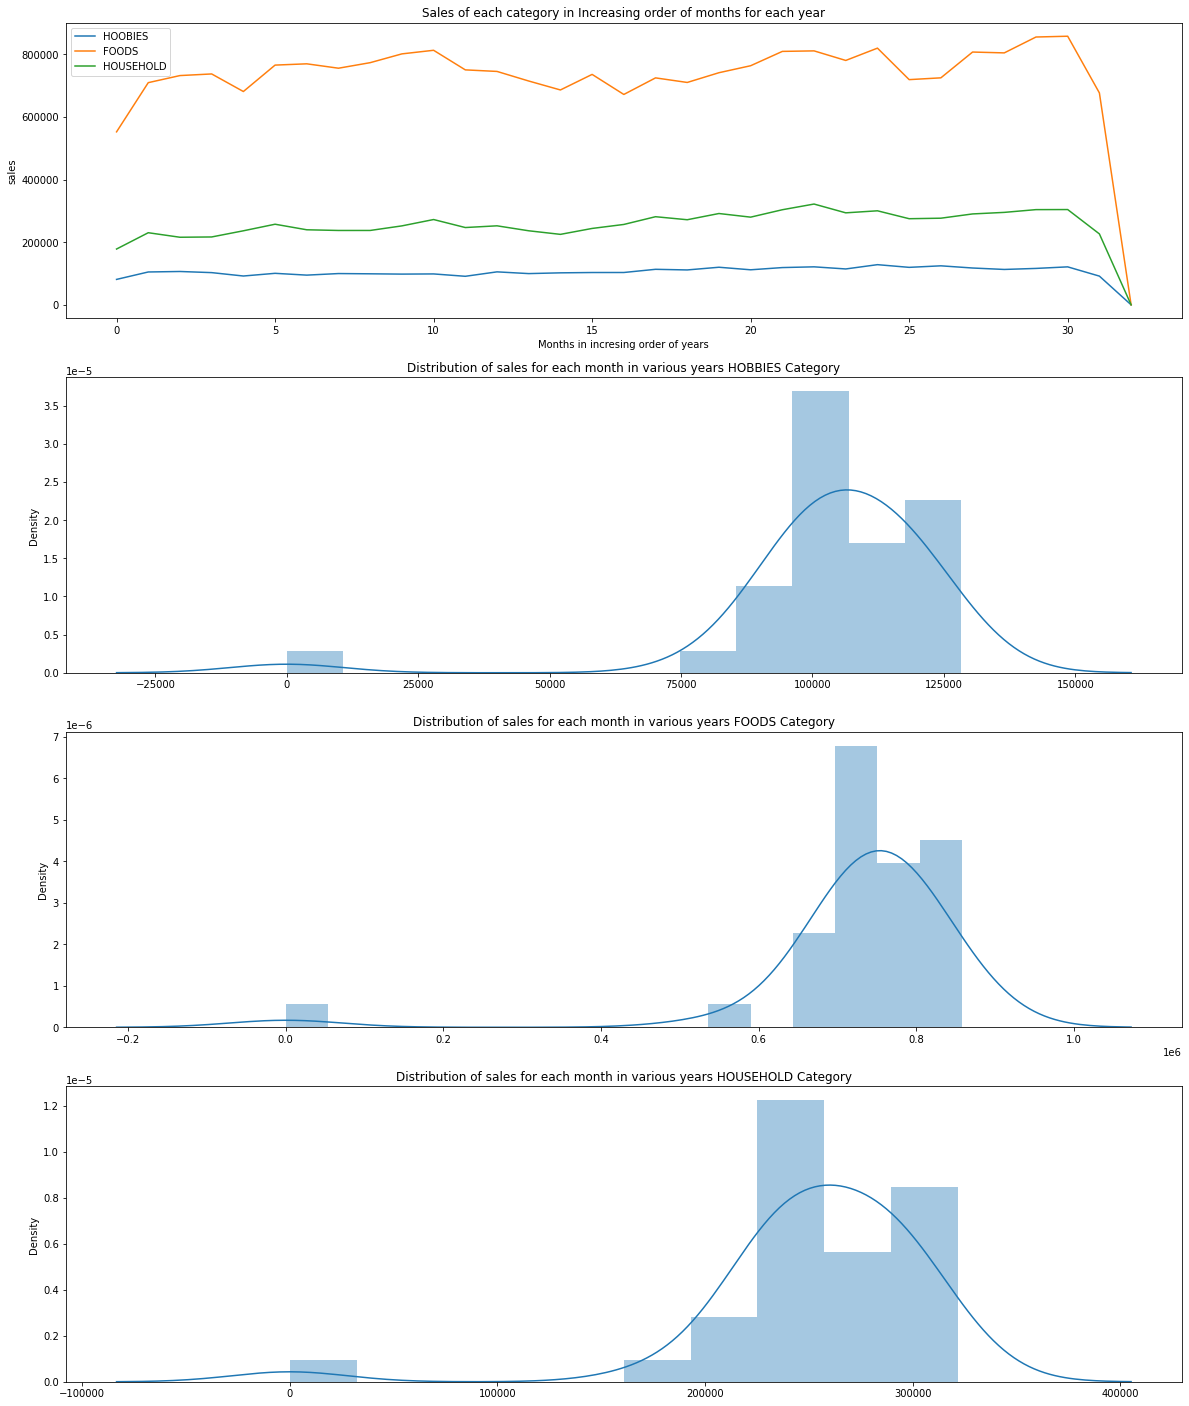

In [42]:
df=data.groupby(['year','month','cat_id']).sum()
df.reset_index(level=[0,1,2],inplace=True)
plt.figure(figsize=(20,25))
plt.subplot(411)
plt.plot(df[df['cat_id']=="HOBBIES"]['demand'].values,label="HOOBIES")
plt.plot(df[df['cat_id']=="FOODS"]['demand'].values,label="FOODS")
plt.plot(df[df['cat_id']=="HOUSEHOLD"]['demand'].values,label="HOUSEHOLD")
plt.xlabel('Months in incresing order of years')
plt.ylabel('sales')
plt.title("Sales of each category in Increasing order of months for each year")
plt.legend()
plt.subplot(412)
sns.distplot(df[df['cat_id']=="HOBBIES"]['demand'].values)
plt.title("Distribution of sales for each month in various years HOBBIES Category")

plt.subplot(413)
sns.distplot(df[df['cat_id']=="FOODS"]['demand'].values)
plt.title("Distribution of sales for each month in various years FOODS Category")

plt.subplot(414)
sns.distplot(df[df['cat_id']=="HOUSEHOLD"]['demand'].values)
plt.title("Distribution of sales for each month in various years HOUSEHOLD Category")

plt.show()

## Linear Regression

In [43]:
# Function to merge datasets returning only one dataframe.
def reshape_and_merge(calendar, sell_prices, sales_train_validation, submission, nrows = 30000000, merge = False):
    
    # Reshaping sales data using melt.
    sales_train_validation = pd.melt(sales_train_validation, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name = 'day', value_name = 'demand')
    print ('Melted sales train validation has {} rows and {} columns'.format(sales_train_validation.shape[0], sales_train_validation.shape[1]))
    sales_trian_validation = reduce_mem_usage(sales_train_validation)
    
    # Preparing test and validation records.
    test_rows = [row for row in submission['id'] if 'validation' in row]
    val_rows = [row for row in submission['id'] if 'evaluation' in row]
    
    test = submission[submission ['id']. isin(test_rows)]
    val = submission[submission ['id']. isin(val_rows)]
    
    # Renaming the columns.
    test.columns = ['id', 'd_1914', 'd_1915', 'd_1916', 'd_1917', 'd_1918', 'd_1919', 'd_1920', 'd_1921',
                    'd_1922', 'd_1923', 'd_1924', 'd_1925', 'd_1926', 'd_1927', 'd_1928', 'd_1929', 'd_1930',
                    'd_1931', 'd_1932', 'd_1933', 'd_1934', 'd_1935', 'd_1936', 'd_1937', 'd_1938', 'd_1939',
                    'd_1940', 'd_1941']
    val.columns = ['id', 'd_1942', 'd_1943', 'd_1944', 'd_1945', 'd_1946', 'd_1947', 'd_1948', 'd_1949',
                   'd_1950', 'd_1951', 'd_1952', 'd_1953', 'd_1954', 'd_1955', 'd_1956', 'd_1957', 'd_1958',
                   'd_1959', 'd_1960', 'd_1961', 'd_1962', 'd_1963', 'd_1964', 'd_1965', 'd_1966', 'd_1967',
                   'd_1968', 'd_1969']
    
    # Getting only product data and removing duplicate records.
    product = sales_train_validation[['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']]. drop_duplicates ()
    
    # Merge with the product table.
    test = test.merge(product, how = 'left', on = 'id')
    val = val.merge(product, how = 'left', on = 'id')
    
    # Reshaping test and validation data.
    test = pd.melt(test, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name = 'day', value_name = 'demand')
    val = pd.melt(val, id_vars = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name = 'day', value_name = 'demand')
    
    # Creating a new column to define training, test and validation data.
    sales_train_validation['part'] = 'train'
    test['part'] = 'test'
    val['part'] = 'val'
    
    # Creating a single dataset with the addition of all training, validation and test records.
    data = pd.concat([sales_train_validation, test, val], axis = 0)
    
    # Removing previous datasets.
    del sales_train_validation, test, val
    
    # Selecting only a few records for training.
    data = data.loc[nrows:]
    
    # Removing validation data.
    data = data[data ['part']!= 'val']
    
    # Performing the merge with calendar and price.
    if merge:
        data = pd.merge(data, calendar, how = 'left', left_on = ['day'], right_on = ['d'])
        data.drop(['d', 'day', 'weekday'], inplace = True, axis = 1)
        data = data.merge(sell_prices, on = ['store_id', 'item_id', 'wm_yr_wk'], how = 'left')
        print('Final dataset for training has {} rows and {} columns'.format(data.shape [0], data.shape [1]))
        del calendar,sell_prices,product
        gc.collect()
    else:
        pass
    
    return data

# Function for handling missing values and transformation of categorical/numeric features
def transform2(data):
    
    # Performing treatment on missing values for the categorical features.
    nan_features_cat = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
    for feature in nan_features_cat:
        data[feature] .fillna('unknown', inplace = True)
    
    # Performing treatment on missing values for the sell_price feature.
    data['sell_price']. fillna(0, inplace = True)
        
    # Turning features categories into numbers to make predictions.
    encoder = preprocessing.LabelEncoder ()
    data['id_encode'] = encoder.fit_transform(data ['id'])
    
    cat = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id',
           'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
    for feature in cat:
        encoder = preprocessing.LabelEncoder()
        data[feature] = encoder.fit_transform(data[feature])
    
    return data

In [44]:
def plotModelResults(model, X_train, X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modeled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = rmse(y_test, prediction)
    plt.title("RMSE: {0:.2f}".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

In [45]:
def prepare_data_lr(data, lag_start, lag_end, test_size, target_encoding=False):

    # lags of series
    for i in range(7, 29):
        data["lag_{}".format(i)] = data['demand'].shift(i)

    # datetime features
    data.index = pd.to_datetime(data.index)
    data["day"] = data.index.day
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1

    if target_encoding:
        # calculate averages on train set only
        test_index = int(len(data.dropna())*(1-test_size))
        data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', "demand").get, data['weekday']))
        data["day_average"] = list(map(code_mean(data[:test_index], 'day', "demand").get, data['day']))

        # frop encoded variables 
        data.drop(["day", "weekday"], axis=1, inplace=True)
    
    # train-test split
    y = data.dropna()['demand']
    X = data.dropna().drop(['demand'], axis=1)

    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=test_size)

    return X_train, X_test, y_train, y_test

In [46]:
def code_mean(data, cat_feature, real_feature):
    """
    Returns a dictionary where keys are unique categories of the cat_feature,
    and values are means over real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test  = X.iloc[test_index:]
    y_test  = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [47]:
calendar, sell_prices, sales_train_validation, submission = read_data(False)

Reading files...
Mem. usage decreased to  0.12 Mb (41.9% reduction)
Calendar has 1969 rows and 14 columns
Mem. usage decreased to 130.48 Mb (37.5% reduction)
Sell prices has 6841121 rows and 4 columns
Sales train validation has 30490 rows and 1919 columns
Mem. usage decreased to  2.09 Mb (84.5% reduction)


In [48]:
# Reshaping and merging datasets.
data = reshape_and_merge(calendar, sell_prices, sales_train_validation, submission, merge = True)

# Calling up the data transformation functions.
data = transform2(data)

# Viewing the final dataset header.
data.head()

# Clearing data from memory.
gc.collect()

Melted sales train validation has 58327370 rows and 8 columns
Mem. usage decreased to 3226.27 Mb (9.4% reduction)
Final dataset for training has 29181090 rows and 21 columns


0

In [49]:
# Selecting only 1 item for testing: FOODS_3_634_WI_2.
df = data [(data ['date'] <= '2016-04-24') & (data ['id'] == 'FOODS_3_634_WI_2_validation') & (data ['demand'] > 0) & (data['demand'] <= 15)]

# Selecting only a few columns for analysis and training.
df = df[['date', 'demand', 'dept_id', 'cat_id', 'store_id', 'state_id', 'event_name_1', 'event_type_1', 'snap_WI', 'sell_price']]

# Transforming the date as index.
df = df.set_index('date')

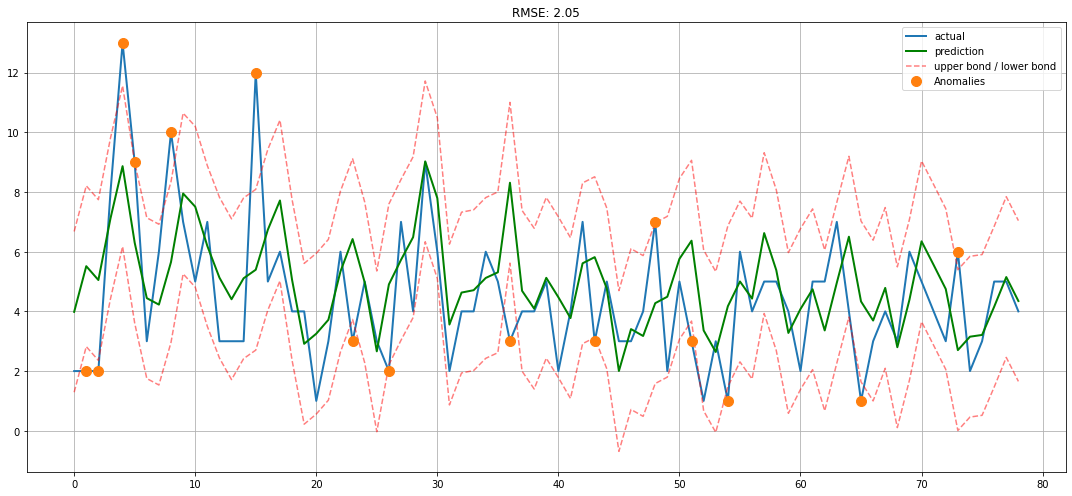

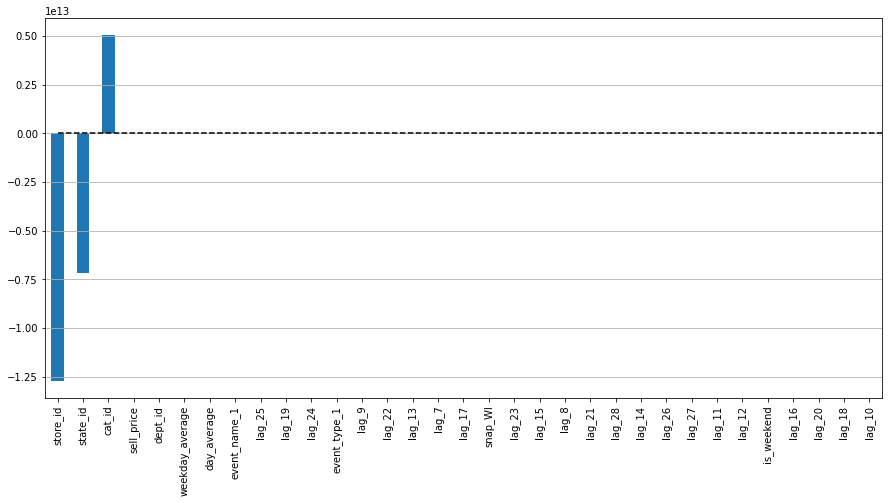

In [50]:
tscv = TimeSeriesSplit (n_splits = 5)

X_train, X_test, y_train, y_test = prepare_data_lr(df, lag_start=1, 
                                               lag_end=29, test_size=0.1, 
                                               target_encoding=True)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True, plot_anomalies=True)
plotCoefficients(lr)

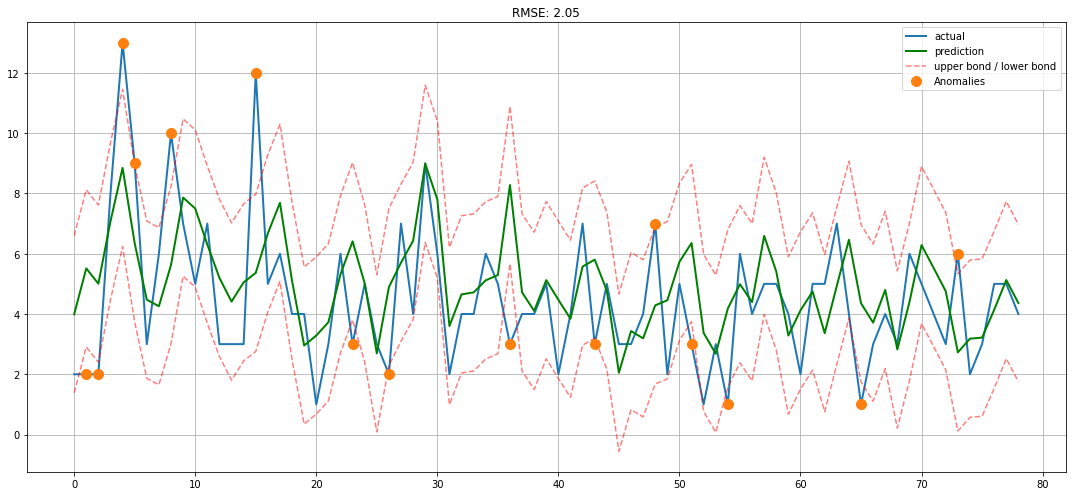

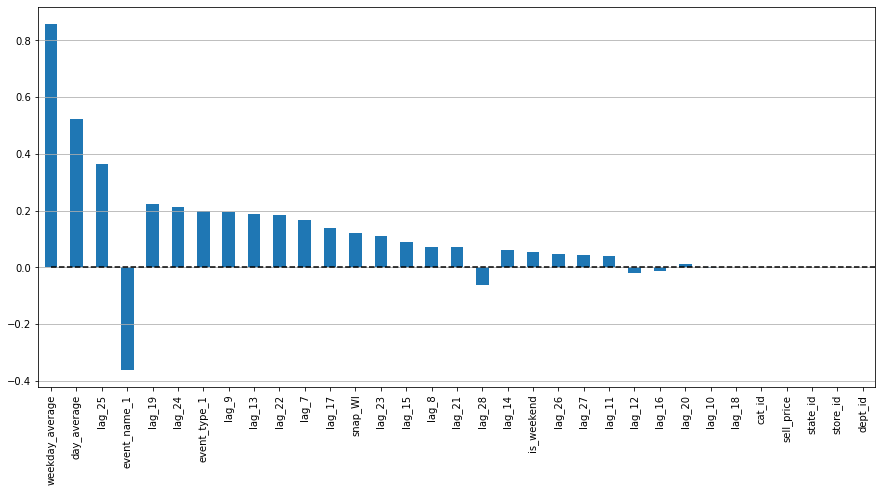

In [51]:
ridge = RidgeCV(cv=tscv)
ridge.fit(X_train_scaled, y_train)

plotModelResults(ridge, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, 
                 plot_anomalies=True)
plotCoefficients(ridge)

## LGBM Regressor

In [57]:
calendar, sell_prices, sales_train_validation, submission = read_data(True)

Reading files...
Mem. usage decreased to  0.12 Mb (41.9% reduction)
Calendar has 1969 rows and 14 columns
Mem. usage decreased to 130.48 Mb (37.5% reduction)
Sell prices has 6841121 rows and 4 columns
Sales train validation has 30490 rows and 1947 columns
Mem. usage decreased to  2.09 Mb (84.5% reduction)


In [58]:
data = melt_and_merge(calendar, sell_prices, sales_train_validation,
                      submission, nrows = 30000000)

Mem. usage decreased to 3273.49 Mb (9.4% reduction)
Our final dataset to train has 30034810 rows and 18 columns


In [59]:
data = transform(data)

fillna and encoded


In [62]:
data['lag_t28'] = data.groupby(['id'])['demand'].apply(lambda x: x.shift(28))
data['lag_t29'] = data.groupby(['id'])['demand'].apply(lambda x: x.shift(29))
data['lag_t30'] = data.groupby(['id'])['demand'].apply(lambda x: x.shift(30))
data['rolling_mean_t7'] = data.groupby(['id'])['demand'].apply(lambda x: x.shift(28).rolling(7).mean())
data['rolling_std_t7'] = data.groupby(['id'])['demand'].apply(lambda x: x.shift(28).rolling(7).std())
data['rolling_mean_t30'] = data.groupby(['id'])['demand'].apply(lambda x: x.shift(28).rolling(30).mean())
data = reduce_mem_usage(data)

Mem. usage decreased to 3084.54 Mb (47.6% reduction)


In [63]:
data['rolling_std_t30'] = data.groupby(['id'])['demand'].apply(lambda x: x.shift(28).rolling(30).std())
data['rolling_skew_t30'] = data.groupby(['id'])['demand'].apply(lambda x: x.shift(28).rolling(30).skew())
data['rolling_kurt_t30'] = data.groupby(['id'])['demand'].apply(lambda x: x.shift(28).rolling(30).kurt())
data['rolling_mean_t90'] = data.groupby(['id'])['demand'].apply(lambda x: x.shift(28).rolling(90).mean())
data['rolling_mean_t180'] = data.groupby(['id'])['demand'].apply(lambda x: x.shift(28).rolling(180).mean())

In [64]:
data['lag_price_t1'] = data.groupby(['id'])['sell_price'].apply(lambda x: x.shift(1))
data['price_change_t1'] = (data['lag_price_t1'] - data['sell_price']) / (data['lag_price_t1'])
data['rolling_price_max_t365'] = data.groupby(['id'])['sell_price'].apply(lambda x: x.shift(1).rolling(365).max())
data['price_change_t365'] = (data['rolling_price_max_t365'] - data['sell_price']) / (data['rolling_price_max_t365'])
data['rolling_price_std_t7'] = data.groupby(['id'])['sell_price'].apply(lambda x: x.rolling(7).std())
data['rolling_price_std_t30'] = data.groupby(['id'])['sell_price'].apply(lambda x: x.rolling(30).std())
data.drop(['rolling_price_max_t365', 'lag_price_t1'], inplace = True, axis = 1)

In [65]:
data['date'] = pd.to_datetime(data['date'])
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['week'] = data['date'].dt.week
data['day'] = data['date'].dt.day
data['dayofweek'] = data['date'].dt.dayofweek
data['isweekend'] = data['dayofweek'].apply(lambda x: 1 if x==5 or x==6 else 0)

In [66]:
data['revenue'] = data['demand'] * data['sell_price']
data['lag_revenue_t1'] = data.groupby(['id'])['revenue'].apply(lambda x: x.shift(28))
data['rolling_revenue_std_t28'] = data.groupby(['id'])['lag_revenue_t1'].apply(lambda x: x.rolling(28).std())
data['rolling_revenue_mean_t28'] = data.groupby(['id'])['lag_revenue_t1'].apply(lambda x: x.rolling(28).mean())
data.drop(['revenue'],axis=1,inplace=True)
data = reduce_mem_usage(data)

Mem. usage decreased to 3972.48 Mb (42.6% reduction)


In [67]:
x_train, y_train, x_val, y_val, test = split_data(data)

In [68]:
features = ['item_id', 'cat_id', 'state_id', 'year', 'month', 'week', 'day', 'dayofweek', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 
            'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'lag_t28', 'lag_t29', 'lag_t30', 'rolling_mean_t7', 'rolling_std_t7', 'rolling_mean_t30', 'rolling_mean_t90', 
            'rolling_mean_t180', 'rolling_std_t30', 'price_change_t1', 'price_change_t365', 'rolling_price_std_t7', 'rolling_price_std_t30', 'rolling_skew_t30', 'rolling_kurt_t30',
            'isweekend','lag_revenue_t1','rolling_revenue_std_t28','rolling_revenue_mean_t28']
category = x_train['dept_id'].unique()
category2 = x_train['store_id'].unique()

from lightgbm import Dataset,train,plot_importance
params = {
    'boosting_type': 'gbdt',
    'metric': 'rmse',
    'objective': 'regression',
    'n_jobs': -1,
    'seed': 236,
    'learning_rate': 0.1}

TEST = None
#i=0
#feature_importances = pd.DataFrame()
#feature_importances['feature'] = features

for i in category:
    for j in category2:
        x_t,x_v,y_t,y_v,t = dataset(i,j)
        train_set = Dataset(x_t[features], y_t)
        val_set = Dataset(x_v[features], y_v)
        del x_t, y_t
        gc.collect()

        model = train(params, train_set, num_boost_round = 5000, early_stopping_rounds = 40, valid_sets = [train_set, val_set], verbose_eval = 1000)
        y_pred = model.predict(t[features])
        t['demand'] = y_pred
        #feature_importances[i] = model.feature_importance()
        #i+=1
        
        TEST = pd.concat([TEST,t],axis=0)
        del x_v, y_v, t, train_set, val_set, y_pred, model
        gc.collect()

'''
feature_importances['average'] = feature_importances[[i for i in range()]].mean(axis=1)
feature_importances.to_csv('lgb_feature_importances.csv')

plt.figure(figsize=(16, 12))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(20), x='average', y='feature');
plt.title('20 TOP feature importance over {} folds average'.format(folds.n_splits));
'''

Training until validation scores don't improve for 40 rounds.
[1000]	training's rmse: 1.19306	valid_1's rmse: 1.26201
[2000]	training's rmse: 1.08074	valid_1's rmse: 1.11463
[3000]	training's rmse: 1.00408	valid_1's rmse: 1.03622
[4000]	training's rmse: 0.944439	valid_1's rmse: 0.975225
[5000]	training's rmse: 0.896005	valid_1's rmse: 0.925215
Did not meet early stopping. Best iteration is:
[5000]	training's rmse: 0.896005	valid_1's rmse: 0.925215
Training until validation scores don't improve for 40 rounds.
[1000]	training's rmse: 1.3611	valid_1's rmse: 1.34702
[2000]	training's rmse: 1.25268	valid_1's rmse: 1.22586
[3000]	training's rmse: 1.1725	valid_1's rmse: 1.15849
[4000]	training's rmse: 1.11196	valid_1's rmse: 1.10556
[5000]	training's rmse: 1.06166	valid_1's rmse: 1.05949
Did not meet early stopping. Best iteration is:
[5000]	training's rmse: 1.06166	valid_1's rmse: 1.05949
Training until validation scores don't improve for 40 rounds.
[1000]	training's rmse: 1.30976	valid_1's 

"\nfeature_importances['average'] = feature_importances[[i for i in range()]].mean(axis=1)\nfeature_importances.to_csv('lgb_feature_importances.csv')\n\nplt.figure(figsize=(16, 12))\nsns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(20), x='average', y='feature');\nplt.title('20 TOP feature importance over {} folds average'.format(folds.n_splits));\n"

In [69]:
predictions1 = TEST[TEST['id'].apply(lambda x: "validation" in x)][['id', 'date', 'demand']]
predictions2 = TEST[TEST['id'].apply(lambda x: "evaluation" in x)][['id', 'date', 'demand']]

In [70]:
prediction1 = pd.pivot(predictions1, index = 'id', columns = 'date', values = 'demand').reset_index()
prediction1.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]

In [71]:
prediction2 = pd.pivot(predictions2, index = 'id', columns = 'date', values = 'demand').reset_index()
prediction2.columns = ['id'] + ['F' + str(i + 1) for i in range(28)]

In [72]:
predictions = pd.concat([prediction1,prediction2],axis=0)
predictions.to_csv("lgbm_submission.csv",index=False)